Results for sub-011_ses-01_recording-01_time-0-72h_sr-1hz.csv:
  timePeriod  microboutCount  Timestamp  microboutsPerHour
0       Dark             303  59.999722           5.050023
1      Light             367  71.995278           5.097557

Results for sub-010_ses-01_recording-01_time-0-69h_sr-1hz.csv:
  timePeriod  microboutCount  Timestamp  microboutsPerHour
0       Dark             122  59.999722           2.033343
1      Light             218  69.639722           3.130397

Results for sub-007_ses-01_recording-01_time-0-70.5h_sr-1hz.csv:
  timePeriod  microboutCount  Timestamp  microboutsPerHour
0       Dark             292  59.999722           4.866689
1      Light             361  70.995278           5.084845

t-statistic: 1.3970174465415726
p-value: 0.2972316922279655
Fail to reject null hypothesis: Light and Dark microbouts per hour are not significantly different.


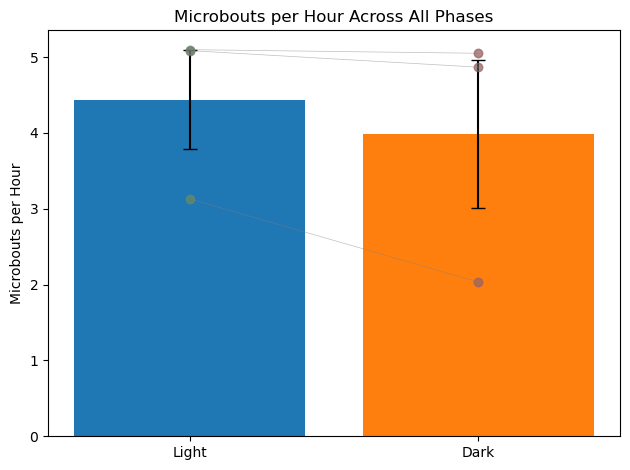

In [9]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# List of CSV file paths
csv_files = glob.glob('/Volumes/harris/volkan/sleep_profile/downsample_auto_score/bout_duration/*.csv')

# Dictionary to store results
results = {}

for file in csv_files:
    # Load the CSV file
    df = pd.read_csv(file)
    
    # Convert Timestamp column to datetime format
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Round the numbers in the sleepStage column to the nearest integer
    df['sleepStage'] = df['sleepStage'].round().astype(int)
    
    # Create a new column to track changes in sleep stage
    df['sleepStageChange'] = df['sleepStage'] != df['sleepStage'].shift()
    
    # Create a cumulative sum of changes to identify continuous instances
    df['boutId'] = df['sleepStageChange'].cumsum()
    
    # Determine the time period (light or dark) for each row
    def get_time_period(row):
        hour = row['Timestamp'].hour
        if 9 <= hour < 21:
            return 'Light'
        else:
            return 'Dark'
    
    df['timePeriod'] = df.apply(get_time_period, axis=1)
    
    # Group by boutId and sleepStage, then calculate the count of rows for each bout
    bout_durations = df.groupby(['boutId', 'sleepStage']).size().reset_index(name='boutDuration')
    
    # Filter microbouts (bout duration less than 10 seconds)
    microbouts = bout_durations[bout_durations['boutDuration'] < 10]
    
    # Determine the time period for each microbout based on the majority time
    microbout_time_periods = df.groupby('boutId')['timePeriod'].apply(lambda x: x.value_counts().index[0]).reset_index()
    
    # Merge the microbouts with the time periods
    microbouts = pd.merge(microbouts, microbout_time_periods, on='boutId')
    
    # Map sleep stages to their corresponding names (optional)
    sleep_stage_map = {1: 'Wake', 2: 'NREM', 3: 'REM'}
    microbouts['sleepStage'] = microbouts['sleepStage'].map(sleep_stage_map)
    
    # Calculate total microbouts per hour for each time period
    microbouts_per_hour = microbouts.groupby('timePeriod')['boutDuration'].size().reset_index(name='microboutCount')
    
    # Calculate total hours for each time period
    total_hours = df.groupby('timePeriod')['Timestamp'].apply(lambda x: (x.max() - x.min()).total_seconds() / 3600).reset_index()
    
    # Merge microbouts per hour with total hours
    microbouts_per_hour = pd.merge(microbouts_per_hour, total_hours, on='timePeriod')
    
    # Calculate cumulative microbouts per hour
    microbouts_per_hour['microboutsPerHour'] = microbouts_per_hour['microboutCount'] / microbouts_per_hour['Timestamp']
    
    # Store results in dictionary
    filename = file.split('/')[-1]
    results[filename] = {
        'microbouts': microbouts,
        'microbouts_per_hour': microbouts_per_hour
    }

# Print results
for filename, result in results.items():
    print(f"Results for {filename}:")
    print(result['microbouts_per_hour'])
    print()

# Create lists to store light and dark microbouts per hour
light_microbouts_per_hour = []
dark_microbouts_per_hour = []

for filename, result in results.items():
    light_microbout_per_hour = result['microbouts_per_hour'].loc[result['microbouts_per_hour']['timePeriod'] == 'Light', 'microboutsPerHour'].values[0]
    dark_microbout_per_hour = result['microbouts_per_hour'].loc[result['microbouts_per_hour']['timePeriod'] == 'Dark', 'microboutsPerHour'].values[0]
    light_microbouts_per_hour.append(light_microbout_per_hour)
    dark_microbouts_per_hour.append(dark_microbout_per_hour)

# Run paired samples t-test
t_stat, p_val = stats.ttest_rel(light_microbouts_per_hour, dark_microbouts_per_hour)

print("t-statistic:", t_stat)
print("p-value:", p_val)

# Interpret p-value
alpha = 0.05
if p_val < alpha:
    print("Reject null hypothesis: Light and Dark microbouts per hour are significantly different.")
else:
    print("Fail to reject null hypothesis: Light and Dark microbouts per hour are not significantly different.")

# Create a figure and axis
fig, ax = plt.subplots()

# Define bar positions and width
bar_width = 0.8
bar_positions = np.arange(2)

# Create bars for Light and Dark periods
light_mean = np.mean(light_microbouts_per_hour)
dark_mean = np.mean(dark_microbouts_per_hour)
light_sem = stats.sem(light_microbouts_per_hour)
dark_sem = stats.sem(dark_microbouts_per_hour)

ax.bar(bar_positions[0], light_mean, bar_width, label='Light', capsize=5, yerr=light_sem)
ax.bar(bar_positions[1], dark_mean, bar_width, label='Dark', capsize=5, yerr=dark_sem)

# Add lines connecting individual subject means
for i in range(len(light_microbouts_per_hour)):
    ax.plot(bar_positions, [light_microbouts_per_hour[i], dark_microbouts_per_hour[i]], 'o-', linewidth=0.5, color='gray', alpha=0.5)

# Add scatter plot for individual means
ax.scatter(np.repeat(bar_positions[0], len(light_microbouts_per_hour)), light_microbouts_per_hour, alpha=0.5)
ax.scatter(np.repeat(bar_positions[1], len(dark_microbouts_per_hour)), dark_microbouts_per_hour, alpha=0.5)

# Set x-axis ticks and labels
ax.set_xticks(bar_positions)
ax.set_xticklabels(['Light', 'Dark'])

# Add legend and labels
ax.set_ylabel('Microbouts per Hour')
ax.set_title('Microbouts per Hour Across All Phases')

# Show plot
plt.tight_layout()
plt.show()

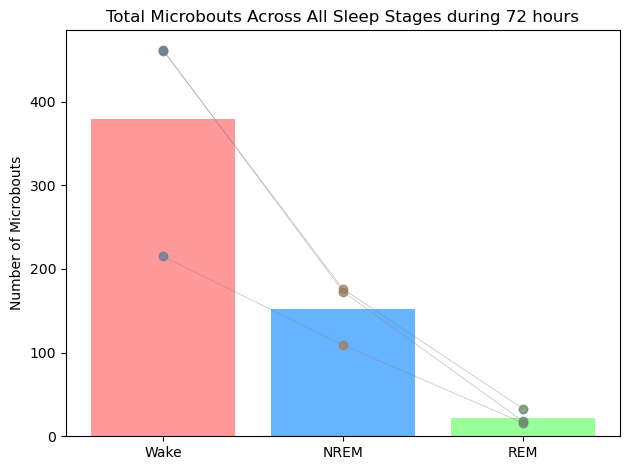

F-statistic: 13.490117729910134
p-value: 0.006021330913902709
Reject null hypothesis: Microbouts differ significantly across sleep stages.


In [11]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# List of CSV file paths
csv_files = glob.glob('/Volumes/harris/volkan/sleep_profile/downsample_auto_score/bout_duration/*.csv')

# Dictionary to store results
results = {}

for file in csv_files:
    # Load the CSV file
    df = pd.read_csv(file)
    
    # Convert Timestamp column to datetime format
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Round the numbers in the sleepStage column to the nearest integer
    df['sleepStage'] = df['sleepStage'].round().astype(int)
    
    # Create a new column to track changes in sleep stage
    df['sleepStageChange'] = df['sleepStage'] != df['sleepStage'].shift()
    
    # Create a cumulative sum of changes to identify continuous instances
    df['boutId'] = df['sleepStageChange'].cumsum()
    
    # Determine the time period (light or dark) for each row
    def get_time_period(row):
        hour = row['Timestamp'].hour
        if 9 <= hour < 21:
            return 'Light'
        else:
            return 'Dark'
    
    df['timePeriod'] = df.apply(get_time_period, axis=1)
    
    # Group by boutId and sleepStage, then calculate the count of rows for each bout
    bout_durations = df.groupby(['boutId', 'sleepStage']).size().reset_index(name='boutDuration')
    
    # Filter microbouts (bout duration less than 10 seconds)
    microbouts = bout_durations[bout_durations['boutDuration'] < 10]
    
    # Determine the time period for each microbout based on the majority time
    microbout_time_periods = df.groupby('boutId')['timePeriod'].apply(lambda x: x.value_counts().index[0]).reset_index()
    
    # Merge the microbouts with the time periods
    microbouts = pd.merge(microbouts, microbout_time_periods, on='boutId')
    
    # Map sleep stages to their corresponding names (optional)
    sleep_stage_map = {1: 'Wake', 2: 'NREM', 3: 'REM'}
    microbouts['sleepStage'] = microbouts['sleepStage'].map(sleep_stage_map)
    
    # Store results in dictionary
    filename = file.split('/')[-1]
    results[filename] = {
        'microbouts': microbouts
    }

# Create lists to store microbouts for each sleep stage
wake_microbouts = []
nrem_microbouts = []
rem_microbouts = []

for filename, result in results.items():
    # Filter microbouts for each sleep stage
    wake = len(result['microbouts'][result['microbouts']['sleepStage'] == 'Wake'])
    nrem = len(result['microbouts'][result['microbouts']['sleepStage'] == 'NREM'])
    rem = len(result['microbouts'][result['microbouts']['sleepStage'] == 'REM'])
    
    wake_microbouts.append(wake)
    nrem_microbouts.append(nrem)
    rem_microbouts.append(rem)

# Calculate mean and standard error for each sleep stage
wake_mean = np.mean(wake_microbouts)
wake_sem = stats.sem(wake_microbouts)
nrem_mean = np.mean(nrem_microbouts)
nrem_sem = stats.sem(nrem_microbouts)
rem_mean = np.mean(rem_microbouts)
rem_sem = stats.sem(rem_microbouts)

# Create a figure and axis
fig, ax = plt.subplots()

# Define bar positions and width
bar_width = 0.8
bar_positions = np.arange(3)

# Create bars for each sleep stage
ax.bar(bar_positions[0], wake_mean, bar_width, label='Wake', color='#ff9999', capsize=5)
ax.bar(bar_positions[1], nrem_mean, bar_width, label='NREM', color='#66b3ff', capsize=5)
ax.bar(bar_positions[2], rem_mean, bar_width, label='REM', color='#99ff99', capsize=5)

# Add lines connecting individual subject means
for i in range(len(wake_microbouts)):
    ax.plot(bar_positions, [wake_microbouts[i], nrem_microbouts[i], rem_microbouts[i]], 'o-', linewidth=0.5, color='gray', alpha=0.5)

# Add scatter plot for individual means
ax.scatter(np.repeat(bar_positions[0], len(wake_microbouts)), wake_microbouts, alpha=0.5)
ax.scatter(np.repeat(bar_positions[1], len(nrem_microbouts)), nrem_microbouts, alpha=0.5)
ax.scatter(np.repeat(bar_positions[2], len(rem_microbouts)), rem_microbouts, alpha=0.5)

# Set x-axis ticks and labels
ax.set_xticks(bar_positions)
ax.set_xticklabels(['Wake', 'NREM', 'REM'])

# Add legend and labels
ax.set_ylabel('Number of Microbouts')
ax.set_title('Total Microbouts Across All Sleep Stages during 72 hours')

# Show plot
plt.tight_layout()
plt.show()

# Run ANOVA to compare microbouts across sleep stages
f_stat, p_val = stats.f_oneway(wake_microbouts, nrem_microbouts, rem_microbouts)

print("F-statistic:", f_stat)
print("p-value:", p_val)

# Interpret p-value
alpha = 0.05
if p_val < alpha:
    print("Reject null hypothesis: Microbouts differ significantly across sleep stages.")
else:
    print("Fail to reject null hypothesis: Microbouts do not differ significantly across sleep stages.")

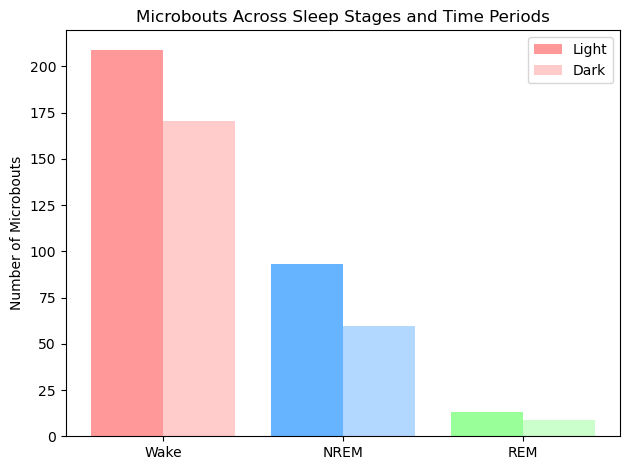

In [24]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np

# List of CSV file paths
csv_files = glob.glob('/Volumes/harris/volkan/sleep_profile/downsample_auto_score/bout_duration/*.csv')

# Dictionary to store results
results = {}

for file in csv_files:
    # Load the CSV file
    df = pd.read_csv(file)
    
    # Convert Timestamp column to datetime format
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Round the numbers in the sleepStage column to the nearest integer
    df['sleepStage'] = df['sleepStage'].round().astype(int)
    
    # Create a new column to track changes in sleep stage
    df['sleepStageChange'] = df['sleepStage'] != df['sleepStage'].shift()
    
    # Create a cumulative sum of changes to identify continuous instances
    df['boutId'] = df['sleepStageChange'].cumsum()
    
    # Determine the time period (light or dark) for each row
    def get_time_period(row):
        hour = row['Timestamp'].hour
        if 9 <= hour < 21:
            return 'Light'
        else:
            return 'Dark'
    
    df['timePeriod'] = df.apply(get_time_period, axis=1)
    
    # Group by boutId and sleepStage, then calculate the count of rows for each bout
    bout_durations = df.groupby(['boutId', 'sleepStage']).size().reset_index(name='boutDuration')
    
    # Filter microbouts (bout duration less than 10 seconds)
    microbouts = bout_durations[bout_durations['boutDuration'] < 10]
    
    # Determine the time period for each microbout based on the majority time
    microbout_time_periods = df.groupby('boutId')['timePeriod'].apply(lambda x: x.value_counts().index[0]).reset_index()
    
    # Merge the microbouts with the time periods
    microbouts = pd.merge(microbouts, microbout_time_periods, on='boutId')
    
    # Map sleep stages to their corresponding names (optional)
    sleep_stage_map = {1: 'Wake', 2: 'NREM', 3: 'REM'}
    microbouts['sleepStage'] = microbouts['sleepStage'].map(sleep_stage_map)
    
    # Store results in dictionary
    filename = file.split('/')[-1]
    results[filename] = {
        'microbouts': microbouts
    }

# Create lists to store microbouts for each sleep stage and time period
wake_light_microbouts = []
wake_dark_microbouts = []
nrem_light_microbouts = []
nrem_dark_microbouts = []
rem_light_microbouts = []
rem_dark_microbouts = []

for filename, result in results.items():
    # Filter microbouts for each sleep stage and time period
    wake_light = len(result['microbouts'][(result['microbouts']['sleepStage'] == 'Wake') & (result['microbouts']['timePeriod'] == 'Light')])
    wake_dark = len(result['microbouts'][(result['microbouts']['sleepStage'] == 'Wake') & (result['microbouts']['timePeriod'] == 'Dark')])
    nrem_light = len(result['microbouts'][(result['microbouts']['sleepStage'] == 'NREM') & (result['microbouts']['timePeriod'] == 'Light')])
    nrem_dark = len(result['microbouts'][(result['microbouts']['sleepStage'] == 'NREM') & (result['microbouts']['timePeriod'] == 'Dark')])
    rem_light = len(result['microbouts'][(result['microbouts']['sleepStage'] == 'REM') & (result['microbouts']['timePeriod'] == 'Light')])
    rem_dark = len(result['microbouts'][(result['microbouts']['sleepStage'] == 'REM') & (result['microbouts']['timePeriod'] == 'Dark')])
    
    wake_light_microbouts.append(wake_light)
    wake_dark_microbouts.append(wake_dark)
    nrem_light_microbouts.append(nrem_light)
    nrem_dark_microbouts.append(nrem_dark)
    rem_light_microbouts.append(rem_light)
    rem_dark_microbouts.append(rem_dark)

# Calculate mean for each sleep stage and time period
wake_light_mean = np.mean(wake_light_microbouts)
wake_dark_mean = np.mean(wake_dark_microbouts)
nrem_light_mean = np.mean(nrem_light_microbouts)
nrem_dark_mean = np.mean(nrem_dark_microbouts)
rem_light_mean = np.mean(rem_light_microbouts)
rem_dark_mean = np.mean(rem_dark_microbouts)

# Create a figure and axis
fig, ax = plt.subplots()

# Define bar positions and width
bar_width = 0.4
bar_positions = np.arange(3)

# Create bars for each sleep stage and time period
ax.bar(bar_positions - bar_width/2, [wake_light_mean, nrem_light_mean, rem_light_mean], bar_width, label='Light', color=['#ff9999', '#66b3ff', '#99ff99'])
ax.bar(bar_positions + bar_width/2, [wake_dark_mean, nrem_dark_mean, rem_dark_mean], bar_width, label='Dark', color=['#ff9999', '#66b3ff', '#99ff99'], alpha=0.5)

# Set x-axis ticks and labels
ax.set_xticks(bar_positions)
ax.set_xticklabels(['Wake', 'NREM', 'REM'])

# Add legend and labels
ax.set_ylabel('Number of Microbouts')
ax.set_title('Microbouts Across Sleep Stages and Time Periods')
ax.legend()

# Show plot
plt.tight_layout()
plt.show()


Total light hours: 104.63111111111111
Total dark hours: 108.0


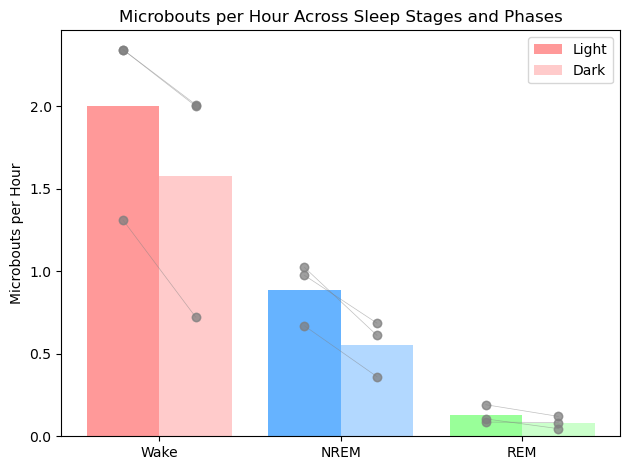

In [9]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np

# List of CSV file paths
csv_files = glob.glob('/Volumes/harris/volkan/sleep_profile/downsample_auto_score/bout_duration/*.csv')

# Calculate total hours in light and dark phases
light_hours = []
dark_hours = []

for file in csv_files:
    # Load the CSV file
    df = pd.read_csv(file)
    
    # Convert Timestamp column to datetime format
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y-%m-%d %H:%M:%S')
    
    # Determine the time period (light or dark) for each row
    def get_time_period(row):
        hour = row['Timestamp'].hour
        if 9 <= hour < 21:
            return 'Light'
        else:
            return 'Dark'
    
    df['timePeriod'] = df.apply(get_time_period, axis=1)
    
    # Calculate total hours in light and dark phases
    light_hours_file = len(df[df['timePeriod'] == 'Light'])
    dark_hours_file = len(df[df['timePeriod'] == 'Dark'])
    
    # Convert seconds to hours
    light_hours_file /= 3600
    dark_hours_file /= 3600
    
    light_hours.append(light_hours_file)
    dark_hours.append(dark_hours_file)

# Calculate total hours across all files
total_light_hours = np.sum(light_hours)
total_dark_hours = np.sum(dark_hours)

print("Total light hours:", total_light_hours)
print("Total dark hours:", total_dark_hours)

# Dictionary to store results
results = {}

for file in csv_files:
    # Load the CSV file
    df = pd.read_csv(file)
    
    # Convert Timestamp column to datetime format
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y-%m-%d %H:%M:%S')
    
    # Round the numbers in the sleepStage column to the nearest integer
    df['sleepStage'] = df['sleepStage'].round().astype(int)
    
    # Create a new column to track changes in sleep stage
    df['sleepStageChange'] = df['sleepStage'] != df['sleepStage'].shift()
    
    # Create a cumulative sum of changes to identify continuous instances
    df['boutId'] = df['sleepStageChange'].cumsum()
    
    # Determine the time period (light or dark) for each row
    def get_time_period(row):
        hour = row['Timestamp'].hour
        if 9 <= hour < 21:
            return 'Light'
        else:
            return 'Dark'
    
    df['timePeriod'] = df.apply(get_time_period, axis=1)
    
    # Group by boutId and sleepStage, then calculate the count of rows for each bout
    bout_durations = df.groupby(['boutId', 'sleepStage']).size().reset_index(name='boutDuration')
    
    # Filter microbouts (bout duration less than 10 seconds)
    microbouts = bout_durations[bout_durations['boutDuration'] < 10]
    
    # Determine the time period for each microbout based on the majority time
    microbout_time_periods = df.groupby('boutId')['timePeriod'].apply(lambda x: x.value_counts().index[0]).reset_index()
    
    # Merge the microbouts with the time periods
    microbouts = pd.merge(microbouts, microbout_time_periods, on='boutId')
    
    # Map sleep stages to their corresponding names (optional)
    sleep_stage_map = {1: 'Wake', 2: 'NREM', 3: 'REM'}
    microbouts['sleepStage'] = microbouts['sleepStage'].map(sleep_stage_map)
    
    # Store results in dictionary
    filename = file.split('/')[-1]
    results[filename] = {
        'microbouts': microbouts
    }

# Create lists to store microbouts per hour for each sleep stage and time period
wake_light_microbouts_per_hour = []
wake_dark_microbouts_per_hour = []
nrem_light_microbouts_per_hour = []
nrem_dark_microbouts_per_hour = []
rem_light_microbouts_per_hour = []
rem_dark_microbouts_per_hour = []

for filename, result in results.items():
    # Filter microbouts for each sleep stage and time period
    wake_light = len(result['microbouts'][(result['microbouts']['sleepStage'] == 'Wake') & (result['microbouts']['timePeriod'] == 'Light')])
    wake_dark = len(result['microbouts'][(result['microbouts']['sleepStage'] == 'Wake') & (result['microbouts']['timePeriod'] == 'Dark')])
    nrem_light = len(result['microbouts'][(result['microbouts']['sleepStage'] == 'NREM') & (result['microbouts']['timePeriod'] == 'Light')])
    nrem_dark = len(result['microbouts'][(result['microbouts']['sleepStage'] == 'NREM') & (result['microbouts']['timePeriod'] == 'Dark')])
    rem_light = len(result['microbouts'][(result['microbouts']['sleepStage'] == 'REM') & (result['microbouts']['timePeriod'] == 'Light')])
    rem_dark = len(result['microbouts'][(result['microbouts']['sleepStage'] == 'REM') & (result['microbouts']['timePeriod'] == 'Dark')])
    
    wake_light_microbouts_per_hour.append(wake_light / total_light_hours)
    wake_dark_microbouts_per_hour.append(wake_dark / total_dark_hours)
    nrem_light_microbouts_per_hour.append(nrem_light / total_light_hours)
    nrem_dark_microbouts_per_hour.append(nrem_dark / total_dark_hours)
    rem_light_microbouts_per_hour.append(rem_light / total_light_hours)
    rem_dark_microbouts_per_hour.append(rem_dark / total_dark_hours)

# Calculate mean microbouts per hour for each sleep stage and time period
wake_light_mean = np.mean(wake_light_microbouts_per_hour)
wake_dark_mean = np.mean(wake_dark_microbouts_per_hour)
nrem_light_mean = np.mean(nrem_light_microbouts_per_hour)
nrem_dark_mean = np.mean(nrem_dark_microbouts_per_hour)
rem_light_mean = np.mean(rem_light_microbouts_per_hour)
rem_dark_mean = np.mean(rem_dark_microbouts_per_hour)

# Create a figure and axis
fig, ax = plt.subplots()

# Define bar positions and width
bar_width = 0.4
bar_positions = np.arange(3)

# Create bars for each sleep stage and time period
ax.bar(bar_positions - bar_width/2, [wake_light_mean, nrem_light_mean, rem_light_mean], bar_width, label='Light', color=['#ff9999', '#66b3ff', '#99ff99'])
ax.bar(bar_positions + bar_width/2, [wake_dark_mean, nrem_dark_mean, rem_dark_mean], bar_width, label='Dark', color=['#ff9999', '#66b3ff', '#99ff99'], alpha=0.5)

# Add lines connecting individual subject means
for i in range(len(wake_light_microbouts_per_hour)):
    ax.plot([0 - bar_width/2, 0 + bar_width/2], [wake_light_microbouts_per_hour[i], wake_dark_microbouts_per_hour[i]], 'o-', linewidth=0.5, color='gray', alpha=0.5)
    ax.plot([1 - bar_width/2, 1 + bar_width/2], [nrem_light_microbouts_per_hour[i], nrem_dark_microbouts_per_hour[i]], 'o-', linewidth=0.5, color='gray', alpha=0.5)
    ax.plot([2 - bar_width/2, 2 + bar_width/2], [rem_light_microbouts_per_hour[i], rem_dark_microbouts_per_hour[i]], 'o-', linewidth=0.5, color='gray', alpha=0.5)

ax.scatter(np.repeat(0 - bar_width/2, len(wake_light_microbouts_per_hour)), wake_light_microbouts_per_hour, alpha=0.5, color='gray')
ax.scatter(np.repeat(0 + bar_width/2, len(wake_dark_microbouts_per_hour)), wake_dark_microbouts_per_hour, alpha=0.5, color='gray')
ax.scatter(np.repeat(1 - bar_width/2, len(nrem_light_microbouts_per_hour)), nrem_light_microbouts_per_hour, alpha=0.5, color='gray')
ax.scatter(np.repeat(1 + bar_width/2, len(nrem_dark_microbouts_per_hour)), nrem_dark_microbouts_per_hour, alpha=0.5, color='gray')
ax.scatter(np.repeat(2 - bar_width/2, len(rem_light_microbouts_per_hour)), rem_light_microbouts_per_hour, alpha=0.5, color='gray')
ax.scatter(np.repeat(2 + bar_width/2, len(rem_dark_microbouts_per_hour)), rem_dark_microbouts_per_hour, alpha=0.5, color='gray')

# Set x-axis ticks and labels
ax.set_xticks(bar_positions)
ax.set_xticklabels(['Wake', 'NREM', 'REM'])

# Add legend and labels
ax.set_ylabel('Microbouts per Hour')
ax.set_title('Microbouts per Hour Across Sleep Stages and Phases')
ax.legend()

# Show plot
plt.tight_layout()
plt.show()